In [18]:
%load_ext autoreload
%autoreload 2
import glob

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from tqdm import tqdm

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.6.dev9+ge632939 anndata==0.7rc1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


## Data folder

In [19]:
splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 1.0K
drwxr-xr-x 2 olga czb 4.0K Oct 13 10:14 .
drwxr-xr-x 7 olga czb 4.0K Oct 13 10:15 ..


# function for multiprocessing splicing

In [33]:
%%file splicing_utils.py

import itertools
from functools import partial
import multiprocessing
import sys
import tempfile
import time

import numpy as np
import pandas as pd

_quiet = False
_debug = False
def set_quiet(val, print_debug=False):
    global _quiet, _debug
    _quiet = bool(val)
    _debug = bool(print_debug)



# Cribbed from https://github.com/dib-lab/sourmash/blob/c7ed8bef7de9b1581b9b067517f64ac64f31f9d0/sourmash/logging.py
def notify(s, *args, **kwargs):
    "A simple logging function => stderr."
    if _quiet:
        return

    print(u'\r\033[K', end=u'', file=sys.stderr)
    print(s.format(*args, **kwargs), file=sys.stderr,
          end=kwargs.get('end', u'\n'))
    if kwargs.get('flush'):
        sys.stderr.flush()



def process_splicing(filename, gene='geneR1A_uniq', cell='cell', tissue=None, method='10x'):
    splicing_df = pd.read_parquet(filename)
    
    
    # Add cell ids that match the h5ad object
    if method == '10x':
        # regex builder: https://regex101.com/r/rE1xfN/1
        matches = splicing_df[cell].str.extractall('(?P<channel_cleaned>[\w-]+)_S\d+_L\d+_(?P<cell_barcode>[ACGT]+)')
        matches = matches.droplevel(-1)
        splicing_df = pd.concat([splicing_df, matches], axis=1)
        splicing_df['cell_id'] = splicing_df['cell_barcode'].astype(str) + '_' + splicing_df['channel_cleaned'].astype(str)
    elif method == 'ss2_tsp1':
        splicing_df['cell_id'] = splicing_df['cell'].astype(str) + '.homo.gencode.v30.ERCC.chrM'
    elif method == "ss2_tsp2":
        splicing_df['cell_id'] = splicing_df['cell']

    # Drop duplicate cell ids and gene names
    splicing_df_no_dups = splicing_df.drop_duplicates(['cell_id', gene])

    
    if tissue is not None:
        splicing_df_no_dups = splicing_df_no_dups.query('tissue == @tissue')
        
    
    # Don't use rows with empty gene names -- these are unannotated genes
    splicing_df_no_dups = splicing_df_no_dups.query(f'{gene} != ""')
    print(splicing_df_no_dups.shape)
    splicing_df_no_dups.head()
    
#     splicing2d = splicing_df_no_dups.pivot(index='cell_id', columns=gene, values='z')
    return splicing_df_no_dups


def my_nan_euclidean_metric(row_i, row_j):
    #     assert row_i.shape == row_j.shape

    i_missing = np.isnan(row_i)
    j_missing = np.isnan(row_j)

    shared = (~i_missing) & (~j_missing)
    n_shared = shared.sum()
    if n_shared == 0:
        return 0
    weight = row_i.shape[0] / n_shared

    i_shared = row_i[shared]
    j_shared = row_j[shared]

    sum_of_squares = np.sum(np.square(i_shared - j_shared))
    distance = np.sqrt(weight * sum_of_squares)
    return distance


def to_memmap(array):
    """Write a memory mapped array
    Create a memory-map to an array stored in a binary file on disk.
    Memory-mapped files are used for accessing small segments of
    large files on disk, without reading the entire file into memory.
    :param np.array array to memory map
    :return: np.array large_memmap memory mapped array
    :return: str filename name of the file that memory mapped array is written to
    """
    import numpy as np

    filename = tempfile.NamedTemporaryFile(
        prefix="array", suffix=".mmap", delete=False
    ).name
    shape = array.shape
    f = np.memmap(filename, mode="w+", shape=shape, dtype=array.dtype)
    f[:] = array[:]
    del f
    large_memmap = np.memmap(filename, dtype=array.dtype, shape=shape)
    return large_memmap, filename


def distance_args_unpack(args):
    """Helper function to unpack the arguments. Written to use in pool.imap
    as it can only be given one argument."""
    row_i, row_j = args
    return my_nan_euclidean_metric(row_i, row_j)


def get_distances_at_index(index, matrix):
    """Returns similarities of all the combinations of signature at index in
    the siglist with the rest of the indices starting at index + 1. Doesn't
    redundantly calculate signatures with all the other indices prior to
    index - 1

    :param int index: generate masks from this image
    :param boolean ignore_abundance
        If the sketches are not abundance weighted, or ignore_abundance=True,
        compute Jaccard similarity.

        If the sketches are abundance weighted, calculate the angular
        similarity.
    :param boolean downsample by max_hash if True
    :param siglist list of signatures
    :return: list of similarities for the combinations of signature at index
        with rest of the signatures from index+1
    """
    startt = time.time()
    sig_iterator = itertools.product([matrix[index, :]], matrix[(index + 1) :, :])
    func = partial(distance_args_unpack,)
    similarity_list = list(map(func, sig_iterator))
    notify(
        "comparison for index {} done in {:.5f} seconds",
        index,
        time.time() - startt,
        end="\r",
    )
    return similarity_list


def distances_parallel(matrix, n_jobs):
    """Compare all combinations of signatures and return a matrix
    of similarities. Processes combinations parallely on number of processes
    given by n_jobs

    :param list siglist: list of signatures to compare
    :param boolean ignore_abundance
        If the sketches are not abundance weighted, or ignore_abundance=True,
        compute Jaccard similarity.

        If the sketches are abundance weighted, calculate the angular
        similarity.
    :param boolean downsample by max_hash if True
    :param int n_jobs number of processes to run the similarity calculations on
    :return: np.array similarity matrix
    """

    # Starting time - calculate time to keep track in case of lengthy siglist
    start_initial = time.time()

    # Create a memory map of the siglist using numpy to avoid memory burden
    # while accessing small parts in it
    matrix, _ = to_memmap(np.array(matrix))
    notify("Created memmapped input matrix")

    # Check that length of combinations can result in a square similarity matrix
    length_matrix = len(matrix)
    shape = (length_matrix, length_matrix)

    # Initialize with ones in the diagonal as the similarity of a signature with
    # itself is one
    distances = np.zeros(shape, dtype=np.float64)
    memmap_distances, filename = to_memmap(distances)
    notify("Initialized memmapped similarities matrix")

    # Initialize the function using func.partial with the common arguments like
    # siglist, ignore_abundance, downsample, for computing all the signatures
    # The only changing parameter that will be mapped from the pool is the index
    func = partial(get_distances_at_index, matrix=matrix,)
    notify("Created similarity func")

    # Initialize multiprocess.pool
    pool = multiprocessing.Pool(processes=n_jobs)

    # Calculate chunk size, by default pool.imap chunk size is 1
    chunksize, extra = divmod(length_matrix, n_jobs)
    if extra:
        chunksize += 1
    notify("Calculated chunk size for multiprocessing")

    # This will not generate the results yet, since pool.imap returns a generator
    result = pool.imap(func, range(length_matrix), chunksize=chunksize)
    notify("Initialized multiprocessing pool.imap")

    # Enumerate and calculate similarities at each of the indices
    # and set the results at the appropriate combination coordinate
    # locations inside the similarity matrix
    for index, l in enumerate(result):
        startt = time.time()
        col_idx = index + 1
        for idx_condensed, item in enumerate(l):
            i = index
            j = col_idx + idx_condensed
            memmap_distances[i, j] = memmap_distances[j, i] = item
        notify(
            "Setting similarities matrix for index {} done in {:.5f} seconds",
            index,
            time.time() - startt,
            end="\r",
        )
    notify("Setting similarities completed")

    pool.close()
    pool.join()

    notify(
        "Time taken to compare all pairs parallely is {:.5f} seconds ",
        time.time() - start_initial,
    )
    return np.memmap(filename, dtype=np.float64, shape=shape)


def make2d(splicing_tidy, index='cell_id', values='scaled_z', columns='geneR1A_uniq'):
    data2d = splicing_tidy.pivot(index=index, values=values, columns=columns)
    return data2d


def compute_distances_df(splicing2d, n_jobs):
    dists = distances_parallel(splicing2d, n_jobs=n_jobs)
    dists_df = pd.DataFrame(dists, index=splicing2d.index, columns=splicing2d.index)
    return dists_df

Overwriting splicing_utils.py


## import `splicing_utils` to process splicing

In [58]:
import splicing_utils

## Read h5ad

In [16]:
h5ad = '/home/olga/Pilot1_Pilot2_filtered_ensembl_id_Aug5.ss2_norm.ann.compartment.allgenes.h5ad'
adata = sc.read(h5ad)
adata

Only considering the two last: ['.allgenes', '.h5ad'].
Only considering the two last: ['.allgenes', '.h5ad'].


AnnData object with n_obs × n_vars = 207016 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: 'featur

In [46]:
adata.obs.tissue.value_counts()

Lung               37320
Bladder            25976
Kidney             24237
Muscle             22247
Blood              16834
Thymus             13125
Lymph_Node         10376
Small_Intestine     9567
Vasculature         9213
Pancreas            8893
Spleen              8366
Large_Intestine     8324
Trachea             8033
Bone_Marrow         3649
Skin                 856
Name: tissue, dtype: int64

In [47]:
adata.obs.query('tissue == "Pancreas"').sample(10)

,10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,cell_id,method,donor,10X_replicate,...,manual_cell_ontology_classcollapsed,Propagated Annotationcollapsed,Onclasscollapsed,singlecellNetcollapsed,kNNcollapsed,SVMcollapsed,scANVIcollapsed,miscompartmentalized,log_n_counts,log_n_genes
AAGTTCGGTGGCCTCA_TSP1_exopancreas2_1,TSP1_exopancreas2_1,nan,nan,nan,2,nan,AAGTTCGGTGGCCTCA_TSP1_exopancreas2_1,10X,TSP1,1,...,unassigned,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,9.534307,7.374002
CTATCTATCATGAAAG_TSP1_exopancreas2_3,TSP1_exopancreas2_3,nan,nan,nan,2,nan,CTATCTATCATGAAAG_TSP1_exopancreas2_3,10X,TSP1,3,...,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,False,8.725994,7.484930
TATCAGGCAGAAATCA_TSP1_endopancreas_3,TSP1_endopancreas_3,nan,nan,nan,nan,nan,TATCAGGCAGAAATCA_TSP1_endopancreas_3,10X,TSP1,3,...,unassigned,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,8.073714,5.846439
TCTCCGATCCGCTTAC_TSP1_exopancreas2_2,TSP1_exopancreas2_2,nan,nan,nan,2,nan,TCTCCGATCCGCTTAC_TSP1_exopancreas2_2,10X,TSP1,2,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,macrophage,False,11.832397,8.881975
TGATCTTGTCCACTTC_TSP1_exopancreas2_2,TSP1_exopancreas2_2,nan,nan,nan,2,nan,TGATCTTGTCCACTTC_TSP1_exopancreas2_2,10X,TSP1,2,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,9.942948,7.709757
TGTTCTAGTTCCATTT_TSP1_exopancreas2_2,TSP1_exopancreas2_2,nan,nan,nan,2,nan,TGTTCTAGTTCCATTT_TSP1_exopancreas2_2,10X,TSP1,2,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,10.010547,7.740664
TTACGTTGTCCACGCA_TSP1_exopancreas2_2,TSP1_exopancreas2_2,nan,nan,nan,2,nan,TTACGTTGTCCACGCA_TSP1_exopancreas2_2,10X,TSP1,2,...,unassigned,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,10.582764,8.433159
B107819_M3_S279.homo.gencode.v30.ERCC.chrM,nan,BC1,B107819Blue,Row,Plate 3,B107819,B107819_M3_S279.homo.gencode.v30.ERCC.chrM,smartseq2,TSP1,nan,...,unassigned,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,14.955721,8.367997
TTCCTCTTCTGAACGT_TSP1_exopancreas2_3,TSP1_exopancreas2_3,nan,nan,nan,2,nan,TTCCTCTTCTGAACGT_TSP1_exopancreas2_3,10X,TSP1,3,...,unassigned,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,8.410499,6.416732
AATTCCTAGAACAGGA_TSP1_exopancreas2_3,TSP1_exopancreas2_3,nan,nan,nan,2,nan,AATTCCTAGAACAGGA_TSP1_exopancreas2_3,10X,TSP1,3,...,unassigned,pancreatic acinar cell,cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,8.223895,5.598422


In [17]:
adata.obs.head()

,10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,cell_id,method,donor,10X_replicate,...,manual_cell_ontology_classcollapsed,Propagated Annotationcollapsed,Onclasscollapsed,singlecellNetcollapsed,kNNcollapsed,SVMcollapsed,scANVIcollapsed,miscompartmentalized,log_n_counts,log_n_genes
AAACCCAAGTTGTCGT_TSP1_blood_2,TSP1_blood_2,nan,nan,nan,nan,nan,AAACCCAAGTTGTCGT_TSP1_blood_2,10X,TSP1,2,...,unassigned,T cell,T cell,T cell,T cell,T cell,T cell,False,9.028579,7.628518
AAACGAAAGCCGTTAT_TSP1_blood_2,TSP1_blood_2,nan,nan,nan,nan,nan,AAACGAAAGCCGTTAT_TSP1_blood_2,10X,TSP1,2,...,unassigned,T cell,T cell,T cell,T cell,T cell,T cell,False,8.651199,7.521318
AAAGGATAGTGTTGTC_TSP1_blood_2,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGATAGTGTTGTC_TSP1_blood_2,10X,TSP1,2,...,unassigned,T cell,T cell,T cell,T cell,T cell,T cell,False,8.994669,7.699842
AAAGGGCAGGAACTAT_TSP1_blood_2,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGGCAGGAACTAT_TSP1_blood_2,10X,TSP1,2,...,unassigned,classical monocyte,classical monocyte,classical monocyte,classical monocyte,classical monocyte,classical monocyte,False,9.131947,7.930925
AAAGGGCCAACCAACT_TSP1_blood_2,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGGCCAACCAACT_TSP1_blood_2,10X,TSP1,2,...,unassigned,classical monocyte,classical monocyte,classical monocyte,classical monocyte,classical monocyte,classical monocyte,False,10.058095,8.454040


In [18]:
2+2

4

In [28]:
adata.obs.query('donor == "TSP1"').sample(10)

,10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,cell_id,method,donor,10X_replicate,...,manual_cell_ontology_classcollapsed,Propagated Annotationcollapsed,Onclasscollapsed,singlecellNetcollapsed,kNNcollapsed,SVMcollapsed,scANVIcollapsed,miscompartmentalized,log_n_counts,log_n_genes
ACGATCAGTACTCGCG_TSP1_bladder_3,TSP1_bladder_3,nan,nan,nan,nan,nan,ACGATCAGTACTCGCG_TSP1_bladder_3,10X,TSP1,3,...,mesenchymal cell,mesenchymal cell,fibroblast,mesenchymal cell,mesenchymal stem cell,mesenchymal cell,mesenchymal stem cell,False,9.042749,7.774436
GACAGCCTCTTAGCTT_TSP1_lung_2,TSP1_lung_2,nan,nan,nan,nan,nan,GACAGCCTCTTAGCTT_TSP1_lung_2,10X,TSP1,2,...,basophil,basophil,basophil,basophil,basophil,basophil,basophil,False,8.154788,6.899723
B107909_C13_S287.homo.gencode.v30.ERCC.chrM,nan,BC14,B107909Blue,Row,Plate 4,B107909,B107909_C13_S287.homo.gencode.v30.ERCC.chrM,smartseq2,TSP1,nan,...,unassigned,macrophage,macrophage,macrophage,macrophage,macrophage,macrophage,False,13.673645,7.882692
TGATTCTCACTTCAGA_TSP1_bladder_2,TSP1_bladder_2,nan,nan,nan,nan,nan,TGATTCTCACTTCAGA_TSP1_bladder_2,10X,TSP1,2,...,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,False,8.231642,7.326466
AAGTTCGGTAAGTTGA_TSP1_bladder_3,TSP1_bladder_3,nan,nan,nan,nan,nan,AAGTTCGGTAAGTTGA_TSP1_bladder_3,10X,TSP1,3,...,macrophage,macrophage,macrophage,macrophage,macrophage,macrophage,macrophage,False,8.859790,7.719130
GTAGAGGGTGTCACAT_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,GTAGAGGGTGTCACAT_TSP1_lung_3,10X,TSP1,3,...,unassigned,macrophage,macrophage,macrophage,macrophage,macrophage,macrophage,False,9.897368,8.196988
TCATTCAAGACGAGCT_TSP1_lung_2,TSP1_lung_2,nan,nan,nan,nan,nan,TCATTCAAGACGAGCT_TSP1_lung_2,10X,TSP1,2,...,non-classical monocyte,non-classical monocyte,non-classical monocyte,non-classical monocyte,non-classical monocyte,non-classical monocyte,non-classical monocyte,False,8.479283,7.415175
GTCATCCGTTCCCAAA_TSP1_lung_3,TSP1_lung_3,nan,nan,nan,nan,nan,GTCATCCGTTCCCAAA_TSP1_lung_3,10X,TSP1,3,...,unassigned,macrophage,macrophage,macrophage,macrophage,macrophage,macrophage,False,10.642683,8.591558
TCTATCAGTGAGTAGC_TSP1_exopancreas2_3,TSP1_exopancreas2_3,nan,nan,nan,2,nan,TCTATCAGTGAGTAGC_TSP1_exopancreas2_3,10X,TSP1,3,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,False,9.629577,7.357556
TTACGCCGTTCTCCTG_TSP1_exopancreas2_1,TSP1_exopancreas2_1,nan,nan,nan,2,nan,TTACGCCGTTCTCCTG_TSP1_exopancreas2_1,10X,TSP1,1,...,unassigned,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic ductal cell,False,10.733217,8.655737


In [20]:
muscle_dists_df.sample(10)

cell,TSP1_muscle_1_S13_L00_AAACGAACACTGTTCC,TSP1_muscle_1_S13_L00_AAAGAACCAACGTATC,TSP1_muscle_1_S13_L00_AAAGAACTCGTTCTGC,TSP1_muscle_1_S13_L00_AAAGGGCCAAGACTGG,TSP1_muscle_1_S13_L00_AAAGTCCCAGCAATTC,TSP1_muscle_1_S13_L00_AAATGGAAGCAGATAT,TSP1_muscle_1_S13_L00_AACACACAGTGATTCC,TSP1_muscle_1_S13_L00_AACACACCAGCACACC,TSP1_muscle_1_S13_L00_AACAGGGGTTTACTGG,TSP1_muscle_1_S13_L00_AACCAACAGACTCTAC,...,TSP1_muscle_3_S15_L00_TTTCCTCAGCCTGACC,TSP1_muscle_3_S15_L00_TTTCCTCAGGCCTTCG,TSP1_muscle_3_S15_L00_TTTCCTCGTGAAGCGT,TSP1_muscle_3_S15_L00_TTTCGATAGGTTAAAC,TSP1_muscle_3_S15_L00_TTTCGATCAAGCTGTT,TSP1_muscle_3_S15_L00_TTTGACTAGGGTGAAA,TSP1_muscle_3_S15_L00_TTTGACTCACTGCGAC,TSP1_muscle_3_S15_L00_TTTGGTTCATTGCCGG,TSP1_muscle_3_S15_L00_TTTGGTTTCGGCTTCT,TSP1_muscle_3_S15_L00_TTTGTTGCAACGCATT
cell,,,,,,,,,,,,,,,,,,,,,
TSP1_muscle_1_S13_L00_GTCAGCGCAGACGATG,73.984996,56.859070,50.347889,65.294851,79.361180,56.490799,96.674650,60.636079,53.639780,66.715700,...,77.857214,81.459251,82.929667,65.687125,74.409688,72.805623,64.922482,82.512940,80.461860,77.526531
TSP1_muscle_3_S15_L00_TTTGGTTTCGGCTTCT,71.374711,73.479676,77.696639,76.313683,130.981381,48.568372,150.620055,60.263043,64.745455,74.240065,...,58.442143,40.114559,67.755901,54.713839,63.122826,43.616137,55.612712,74.754644,0.000000,55.982545
TSP1_muscle_3_S15_L00_TTTCCTCGTGAAGCGT,76.858856,74.167948,88.143214,82.938572,129.018571,65.702029,135.521943,71.814628,73.448739,75.796421,...,71.807327,66.450427,0.000000,70.129591,88.237092,67.450479,55.249242,61.027060,67.755901,56.060856
TSP1_muscle_3_S15_L00_TCCACCATCAAAGCCT,79.157764,73.396891,89.533109,87.174603,117.789658,107.376104,123.276605,71.713547,76.292615,82.377699,...,55.177386,61.696675,72.287608,59.398536,79.702063,56.952872,66.481332,70.256005,61.783319,64.026333
TSP1_muscle_1_S13_L00_GAAACCTGTGTTACAC,70.932553,60.995439,70.223257,68.707200,102.809803,60.410976,101.057785,72.489336,54.294086,64.441952,...,73.329657,66.550786,75.218596,67.630781,68.292739,71.019602,60.686553,70.957494,75.440234,63.423610
TSP1_muscle_2_S14_L00_AACCATGGTCTTGCGG,81.872599,78.252220,87.275514,92.678883,113.529537,102.777397,132.799592,73.691601,78.520646,82.914519,...,61.454078,63.562904,63.472924,73.659259,85.643907,65.608842,61.797698,61.542284,62.098947,64.070853
TSP1_muscle_3_S15_L00_GTGTGGCCAAATCAGA,78.336565,77.857195,84.910370,77.371528,96.345100,66.726952,138.020827,71.772207,70.524941,70.256650,...,55.867509,64.408806,70.910607,51.140089,74.472361,57.097166,56.351425,73.434728,56.051420,64.153277
TSP1_muscle_2_S14_L00_GCAGCCATCTGCGATA,91.539229,97.552942,107.102108,98.871229,113.524603,68.956813,159.557334,91.380998,94.144710,93.969580,...,66.537887,65.983271,75.900989,65.812168,82.375298,82.556336,69.928229,63.720564,69.535907,72.825427
TSP1_muscle_2_S14_L00_GTTGCTCTCGATCCCT,87.162694,81.939707,89.095200,93.626840,110.841805,58.991131,129.049723,78.674081,75.732754,68.736678,...,63.307452,62.401715,74.037728,64.305277,73.998019,65.257671,66.247565,70.960427,62.677634,62.599014


# Do all of sapiens

## Data folder

In [25]:
# splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-09-15'
# ! ls -lha $splicing_folder

splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 1.5G
drwxr-xr-x 2 olga czb 4.0K Oct 13 10:48 .
drwxr-xr-x 7 olga czb 4.0K Oct 13 10:15 ..
-rw-r--r-- 1 olga czb 690M Oct 13 10:15 TSP1_10x_nopanc_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 803M Oct 13 10:14 TSP2_10x_3prime_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq


## Read all TS (tabula sapiens) 10x paruqet files

In [29]:
%%time
import splicing_utils

dfs = []
for parquet in glob.glob(f"{splicing_folder}/TSP*10x*.pq"):
    print(parquet)
    df = splicing_utils.process_splicing(parquet, method='10x')
    print(df.shape)
    dfs.append(df)
sapiens_splicing_tidy = pd.concat(dfs)
print(sapiens_splicing_tidy.shape)
sapiens_splicing_tidy.head()

/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13/TSP2_10x_3prime_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
(2701021, 101)
(2701021, 101)
/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13/TSP1_10x_nopanc_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
(2555970, 101)
(2555970, 101)
(5256991, 101)
CPU times: user 2min 25s, sys: 2min 16s, total: 4min 42s
Wall time: 3min 14s


,inc_emp.p,tissue,gene_count_per_cell_filt,juncPosR1A,geneR1A_uniq,juncPosR1B,numReads,cell,channel,splice_ann,...,cov_dom_unch,z_dom_unch,ontology,n.g,scaled_z,zcontribA,zcontribB,channel_cleaned,cell_barcode,cell_id
0,True,Bladder,21.0,100526975.0,NDUFB8,100523929.0,1.0,TSP2_Bladder_NA_10X_1_1_S5_L00_CATACAGGTAACATGA,TSP2_Bladder_NA_10X_1_1_S5_L00,False,...,NaN,NaN,BladderImmunenatural killer cell,21.0,1.273449,-2.890378,2.609321,TSP2_Bladder_NA_10X_1_1,CATACAGGTAACATGA,CATACAGGTAACATGA_TSP2_Bladder_NA_10X_1_1
1,True,Bladder,25.0,100526975.0,NDUFB8,100523929.0,1.0,TSP2_Bladder_NA_10X_1_1_S5_L00_GCTGCAGCATGAGATA,TSP2_Bladder_NA_10X_1_1_S5_L00,False,...,NaN,NaN,BladderImmunenatural killer cell,25.0,1.065466,-2.649075,2.391482,TSP2_Bladder_NA_10X_1_1,GCTGCAGCATGAGATA,GCTGCAGCATGAGATA_TSP2_Bladder_NA_10X_1_1
2,True,Bladder,21.0,100526975.0,NDUFB8,100523929.0,1.0,TSP2_Bladder_NA_10X_1_1_S5_L00_ATTACCTAGTTGGCTT,TSP2_Bladder_NA_10X_1_1_S5_L00,False,...,NaN,NaN,BladderEpithelialintermediate epitheliocyte,21.0,1.343825,-2.890378,2.609321,TSP2_Bladder_NA_10X_1_1,ATTACCTAGTTGGCTT,ATTACCTAGTTGGCTT_TSP2_Bladder_NA_10X_1_1
3,True,Blood,23.0,100526975.0,NDUFB8,100523929.0,1.0,TSP2_Blood_NA_10X_1_3_S15_L00_CTCCTCCAGCTAATGA,TSP2_Blood_NA_10X_1_3_S15_L00,False,...,NaN,NaN,"BloodImmuneCD4-positive, alpha-beta memory T cell",23.0,1.105109,-2.761852,2.493292,TSP2_Blood_NA_10X_1_3,CTCCTCCAGCTAATGA,CTCCTCCAGCTAATGA_TSP2_Blood_NA_10X_1_3
4,True,Blood,9.0,100526975.0,NDUFB8,100523929.0,1.0,TSP2_Blood_NA_10X_1_3_S15_L00_TTGCTGCGTGAATTAG,TSP2_Blood_NA_10X_1_3_S15_L00,False,...,NaN,NaN,"BloodImmuneCD4-positive, alpha-beta memory T cell",8.0,2.990745,-4.682948,4.227583,TSP2_Blood_NA_10X_1_3,TTGCTGCGTGAATTAG,TTGCTGCGTGAATTAG_TSP2_Blood_NA_10X_1_3


In [34]:
%%time

sapiens_splicing_2d = splicing_utils.make2d(sapiens_splicing_tidy)
print(sapiens_splicing_2d.shape)
sapiens_splicing_2d.head()

(59367, 1617)
CPU times: user 5.35 s, sys: 34.7 s, total: 40 s
Wall time: 40.7 s


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Write concatenated (cell, gene) splicing scores to file

In [37]:
concatenated_splicing_folder = f'{splicing_folder}/concatenated'
! mkdir -p $concatenated_splicing_folder

### Write 2d version first to get started on clustering

In [38]:
%%time

sapiens_splicing_2d.to_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_10x_splicing_2d.parquet')

CPU times: user 3.85 s, sys: 502 ms, total: 4.35 s
Wall time: 4.54 s


### Write tall, tidy version

In [39]:
%%time

sapiens_splicing_tidy.to_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_10x_splicing_tidy.parquet')

CPU times: user 23.1 s, sys: 6.05 s, total: 29.1 s
Wall time: 31.3 s


# SS2 - stop here

### Read all TS (tabula sapiens) SS2 paruqet files

In [88]:
%%time

dfs = []
for parquet in glob.glob(f"{splicing_folder}/TS*SS2*.pq"):
    print(parquet)
    if "TSP1" in parquet:
        method = 'ss2_tsp1'
    elif "TSP2" in parquet:
        method = 'ss2_tsp2'
    df = splicing_utils.process_splicing(parquet, method=method)
    print(df.shape)
    dfs.append(df)
sapiens_ss2_splicing_tidy = pd.concat(dfs)
print(sapiens_ss2_splicing_tidy.shape)
sapiens_ss2_splicing_tidy.head()

/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-09-15/TSP2_SS2_sym_S_0.1_z_0.0_b_5.pq
(4163485, 75)
(4163485, 75)
/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-09-15/TSP1_SS2_sym_S_0.1_z_0.0_b_5.pq
(2811472, 93)
(2811472, 93)


/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(6974957, 93)
CPU times: user 3min 56s, sys: 8min 4s, total: 12min
Wall time: 5min 22s


,S_ijk_A,S_ijk_A_unpinned,S_ijk_B,S_ijk_B_unpinned,cell,cell_gene,cell_gene_junc,cell_id,compartment,cov,...,z_A_unann,z_B,z_B_ann,z_B_dom_ch,z_B_dom_unch,z_B_unann,z_ann,z_dom_ch,z_dom_unch,z_unann
0,0.746813,1.384481,-0.748974,-2.514678,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_E20_...,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_E20_...,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_E20_...,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_E20_...,None,-221.520704,...,-0.071210,11.102988,NaN,NaN,NaN,2.127909,NaN,NaN,NaN,-0.152333
59,-0.688247,-0.713331,-0.384270,-0.384270,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,None,-221.520704,...,-1.077126,4.700045,-0.036787,NaN,NaN,0.958533,7.867167,NaN,NaN,-0.036750
60,0.746813,1.630920,-0.748974,-1.425277,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,None,-6.780827,...,-0.363547,-5.259481,NaN,NaN,NaN,-3.591954,NaN,NaN,NaN,4.280136
164,-0.688247,-1.429517,NaN,NaN,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,None,-7.029158,...,-2.575185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.575185
168,0.746813,0.774597,NaN,NaN,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,None,NaN,...,2.361629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.361629


In [97]:
%%time

sapiens_ss2_splicing_2d = sapiens_ss2_splicing_tidy.pivot(index='cell_id', values='z', columns='geneR1A_uniq')
print(sapiens_ss2_splicing_2d.shape)
sapiens_ss2_splicing_2d.head()

(9367, 22103)
CPU times: user 0 ns, sys: 8.75 s, total: 8.75 s
Wall time: 31.2 s


geneR1A_uniq,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A4GALT,AAAS,AACS,...,ZZZ3,bP-21201H5.1,bP-21264C1.1,bP-2171C21.2,bP-2189O9.2,hsa-mir-3179-1,hsa-mir-3687-1,hsa-mir-6724-1,pk,unknown
cell_id,,,,,,,,,,,,,,,,,,,,,
B107809_A11_S131.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A12_S132.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A13_S133.homo.gencode.v30.ERCC.chrM,NaN,NaN,-0.112305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A15_S135.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A18_S138.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Write concatenated (cell, gene) splicing scores to file

In [92]:
%time sapiens_ss2_splicing_tidy.to_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_ss2_splicing_tidy.parquet')

CPU times: user 37.9 s, sys: 7.19 s, total: 45.1 s
Wall time: 1min 5s


In [98]:
%time sapiens_ss2_splicing_2d.to_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_ss2_splicing_2d.parquet')

CPU times: user 0 ns, sys: 10.5 s, total: 10.5 s
Wall time: 18.2 s


## Check file sizes

In [95]:
! ls -lha $concatenated_splicing_folder

total 2.7G
drwxr-xr-x 2 olga czb 4.0K Sep 25 08:24 .
drwxr-xr-x 4 olga czb 4.0K Sep 21 10:08 ..
-rw-r--r-- 1 olga czb  73M Sep 23 08:48 tabula_sapiens_10x_splicing_2d.parquet
-rw-r--r-- 1 olga czb  73M Sep 23 08:43 tabula_sapiens_10x_splicing_tidy.parquet
-rw-r--r-- 1 olga czb  73M Sep 23 08:49 tabula_sapiens_ss2_splicing_2d.parquet
-rw-r--r-- 1 olga czb 2.5G Sep 23 08:49 tabula_sapiens_ss2_splicing_tidy.parquet


In [94]:
2+2

4

# What splicing events are only found in SS2 or 10x?

## Shared

In [103]:
events_shared = sapiens_ss2_splicing_2d.columns.intersection(sapiens_splicing_2d.columns)
print(len(events_shared))
splicing_ss2_shared = sapiens_ss2_splicing_2d[events_shared]
print(splicing_ss2_shared.shape)
splicing_ss2_shared.head()

3816
(9367, 3816)


geneR1A_uniq,A2M,AAAS,AAK1,AAMDC,AARSD1,AASDH,ABCA10,ABCA6,ABCA8,ABCA9,...,ZNF83,ZNF836,ZNF98,ZNHIT1,ZNRF1,ZRANB2,ZRSR2,ZSWIM7,bP-2189O9.2,unknown
cell_id,,,,,,,,,,,,,,,,,,,,,
B107809_A11_S131.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A12_S132.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A13_S133.homo.gencode.v30.ERCC.chrM,-0.112305,NaN,NaN,1.589588,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A15_S135.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,-2.699889,NaN,NaN,0.12454,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A18_S138.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SS2 only

In [100]:
events_in_ss2_only = sapiens_ss2_splicing_2d.columns.difference(sapiens_splicing_2d.columns)
print(len(events_in_ss2_only))
splicing_ss2_only = sapiens_ss2_splicing_2d[events_in_ss2_only]
print(splicing_ss2_only.shape)
splicing_ss2_only.head()

18287
(9367, 18287)


geneR1A_uniq,A1BG-AS1,A1CF,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A4GALT,AACS,AACSP1,AADAC,...,ZYX,ZZEF1,ZZZ3,bP-21201H5.1,bP-21264C1.1,bP-2171C21.2,hsa-mir-3179-1,hsa-mir-3687-1,hsa-mir-6724-1,pk
cell_id,,,,,,,,,,,,,,,,,,,,,
B107809_A11_S131.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A12_S132.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A13_S133.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A15_S135.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A18_S138.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


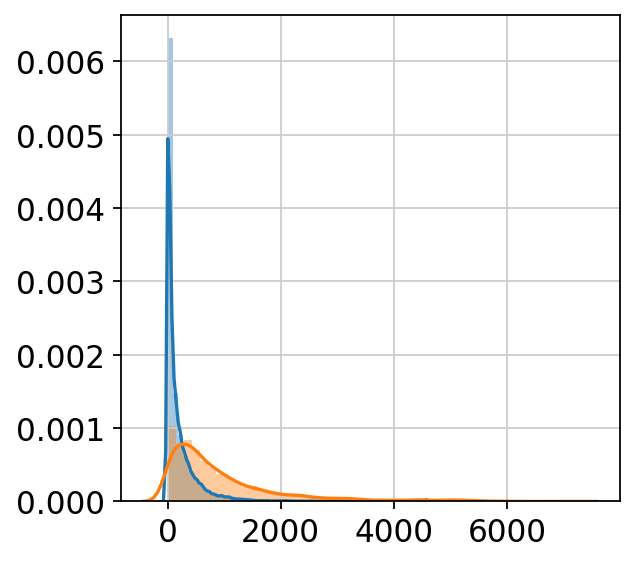

In [105]:
splicing_ss2_only_n_cells_per_gene = splicing_ss2_only.notnull().sum()
sns.distplot(splicing_ss2_only_n_cells_per_gene)
sns.distplot(splicing_ss2_shared.notnull().sum())

In [106]:
splicing_ss2_only.loc[:, splicing_ss2_only_n_cells_per_gene > 1000]

geneR1A_uniq,AAMP,ABI1,AC002985.3,AC003092.1,AC006160.5,AC009065.4,AC092755.4,AC104534.3,ACAT1,ACTN4,...,ZCRB1,ZFP36L1,ZFP36L2,ZFR,ZMYM6NB,ZNF207,ZNFX1,ZYX,hsa-mir-3687-1,hsa-mir-6724-1
cell_id,,,,,,,,,,,,,,,,,,,,,
B107809_A11_S131.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A12_S132.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A13_S133.homo.gencode.v30.ERCC.chrM,11.546694,NaN,NaN,NaN,-2.316113,NaN,NaN,-0.964371,NaN,NaN,...,NaN,NaN,NaN,NaN,0.209916,NaN,NaN,NaN,NaN,NaN
B107809_A15_S135.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,-0.960087,NaN,-0.31068,1.050940,0.004967,1.466724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B107809_A18_S138.homo.gencode.v30.ERCC.chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Spleen_NA_SS2_B114583_B104854_Granulocyte_H5_S173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.504019
TSP2_Spleen_NA_SS2_B114583_B104854_Granulocyte_H6_S174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.975616
TSP2_Spleen_NA_SS2_B114583_B104854_Granulocyte_H7_S175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.936284,-0.961746
